# Extract and load data

**Concatenate all the files to make easier the extraction**

In [7]:
# find people -type f -name "*.txt" -exec cat {} + > all_data.txt

**Extract locations and store them into a file**

In [39]:
import json
import pandas as pd

with open('../data/all_data.txt', 'r', encoding='latin-1') as file:
    lines = file.readlines()

latitudes = []
longitudes = []
altitudes = []
accuracies = []

for idx, line in enumerate(lines):
    try:
        data = json.loads(line)
        if not isinstance(data, dict):
            continue
    except Exception as e:
        continue

    if 'Location' in data:
        data_location = data['Location']
        latitudes.append(data_location['Latitude'])
        longitudes.append(data_location['Longtitude'])
        altitudes.append(data_location['Altitude'])
        accuracies.append(data_location['Accuracy'])

In [80]:
df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Altitude": altitudes, "Accuracy": accuracies})
# df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Accuracy": accuracies})

df_locations.drop_duplicates(inplace=True)

df_locations.to_csv("../data/locations.csv", index=False)

**Load data from the .csv file**

In [98]:
import pandas as pd
df_locations = pd.read_csv("../data/locations.csv")

df_locations['Altitude'] = df_locations['Altitude'].apply(lambda x: x/1000)
# df_locations['Latitude'] = df_locations['Latitude'].apply(lambda x: x*10)


# Clustering

In [105]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3)

kmeans.fit(df_locations.drop('Accuracy', axis=1))
df_locations['Cluster'] = kmeans.predict(df_locations.drop('Accuracy', axis=1))

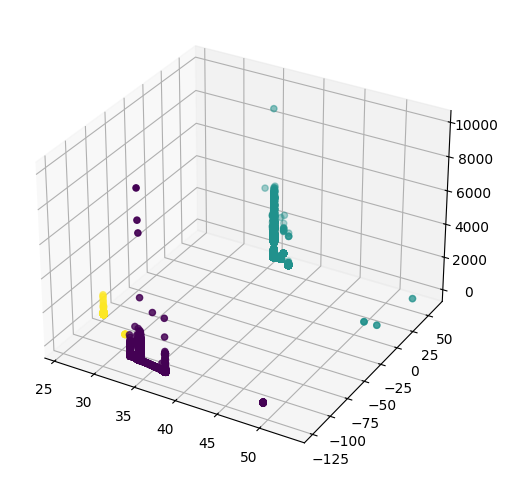

In [107]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_locations['Latitude'], df_locations['Longitude'], df_locations['Accuracy'], c=df_locations['Cluster'])
plt.show()

/tmp/ipykernel_40558/2832709225.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


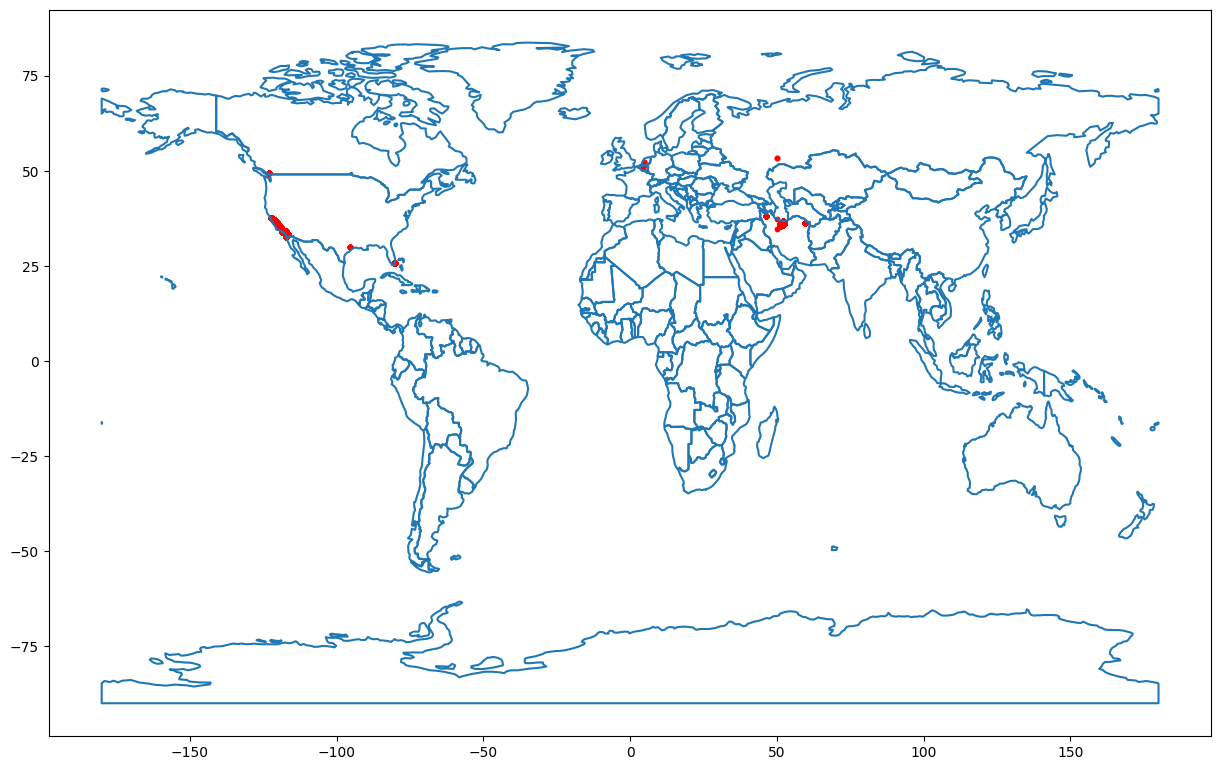

In [108]:
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df_locations['Longitude'], df_locations['Latitude'])]
gdf = gpd.GeoDataFrame(df_locations, geometry=geometry)
gdf.crs = world.crs

fig, ax = plt.subplots(figsize=(15, 15))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, color='red', markersize=10)
plt.show()